In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import asyncio
import time

import matplotlib.pyplot as plt

from ipywidgets import (
    HBox,
    VBox,
    Button,
    Dropdown,
    ToggleButton,
    Label
)
from ipyevents import Event

from park.simulation import Simulation
from park.world import World
from park.render import Camera, Renderer
from park.stats import Curve

from park.internal.math import Rect, Vector2D
from park.internal.physics import Physics
from park.logic.queue import RobotQueue, VisitorQueue

from ai.pathfinding.core import MovementStrategy
from ai.recognition.core import PredictionType

2025-10-25 00:41:11.343061: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 00:41:11.343217: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 00:41:11.363702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 00:41:12.023845: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

In [2]:
from ai.recognition.core import get_recognition_model, train_recognition_model
from ai.recognition.dataset import VisitorDataset
from park.entities.visitor import Visitor

image_size = (16, 16)
dataset = VisitorDataset(image_size=image_size, batch_size=4)

train_size = round(0.5 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

max_visitor_group_size = 3
model = get_recognition_model(
    input_shape=list(image_size) + [4],
    num_group_types=len(Visitor.GroupType),
    max_group_size=max_visitor_group_size
)
if model is not None:
    _, history = train_recognition_model(
        model,
        train_data=train_ds,
        val_data=val_ds,
        epochs=50,
        learning_rate=1e-4
    )

Epoch 1/50


2025-10-25 00:41:12.111904: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - group_size_accuracy: 0.1786 - group_size_loss: 59.0902 - group_type_accuracy: 0.5714 - group_type_loss: 114.3101 - loss: 173.4003 - val_group_size_accuracy: 0.2000 - val_group_size_loss: 47.2990 - val_group_type_accuracy: 0.6800 - val_group_type_loss: 42.6942 - val_loss: 87.0559
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - group_size_accuracy: 0.4286 - group_size_loss: 33.9559 - group_type_accuracy: 0.4286 - group_type_loss: 37.1735 - loss: 71.1294 - val_group_size_accuracy: 0.3000 - val_group_size_loss: 28.1260 - val_group_type_accuracy: 0.6400 - val_group_type_loss: 30.9130 - val_loss: 58.4539
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - group_size_accuracy: 0.4286 - group_size_loss: 28.0905 - group_type_accuracy: 0.5536 - group_type_loss: 27.4463 - loss: 55.5368 - val_group_size_accuracy: 0.6800 - val_group_size_loss: 20.8263 - val_group_type_accuracy: 0.7400 - val_group_type_loss: 21.8052 - val_loss: 43.1066
Epoch 4/50
14/14 ━━

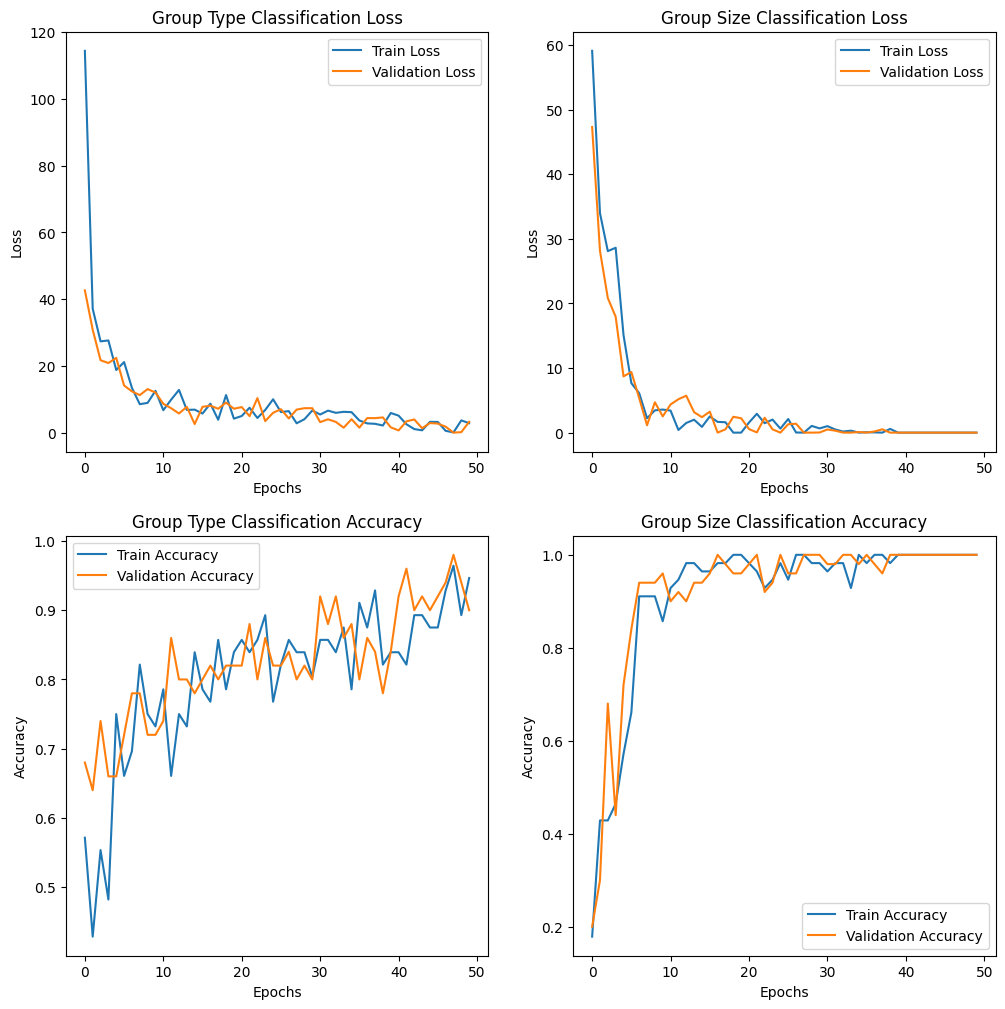

In [3]:
if model is not None:
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()

    axs[0].plot(history.history["group_type_loss"], label="Train Loss")
    axs[0].plot(history.history["val_group_type_loss"], label="Validation Loss")
    axs[0].set_title("Group Type Classification Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history["group_size_loss"], label="Train Loss")
    axs[1].plot(history.history["val_group_size_loss"], label="Validation Loss")
    axs[1].set_title("Group Size Classification Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    axs[2].plot(history.history["group_type_accuracy"], label="Train Accuracy")
    axs[2].plot(history.history["val_group_type_accuracy"], label="Validation Accuracy")
    axs[2].set_title("Group Type Classification Accuracy")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("Accuracy")
    axs[2].legend()

    axs[3].plot(history.history["group_size_accuracy"], label="Train Accuracy")
    axs[3].plot(history.history["val_group_size_accuracy"], label="Validation Accuracy")
    axs[3].set_title("Group Size Classification Accuracy")
    axs[3].set_xlabel("Epochs")
    axs[3].set_ylabel("Accuracy")
    axs[3].legend()

In [4]:
cell_size = 64

world_width = cell_size * 8
world_height = cell_size * 10

cam_width = cell_size * 8
cam_height = cell_size * 10

num_robots = 10
robot_size = Vector2D(18.0, 18.0)

world = World(
    width=world_width,
    height=world_height,
    cell_size=cell_size
)
sim = Simulation(
    world=world,
    starting_funds=10000.0,
    max_visitor_group_size=max_visitor_group_size,
    rng=None
)

charger_size = Vector2D(cell_size / 2, cell_size / 3)
charger_positions = [
    Vector2D(charger_size.x / 2, world_height - charger_size.y / 2 - (cell_size / 2 - charger_size.y) / 2),
    Vector2D(charger_size.x / 2, world_height - 3 * (charger_size.y / 2 + (cell_size / 2 - charger_size.y) / 2)),
    Vector2D(charger_size.x / 2, world_height - 5 * (charger_size.y / 2 + (cell_size / 2 - charger_size.y) / 2)),
    Vector2D(charger_size.x / 2, world_height - 7 * (charger_size.y / 2 + (cell_size / 2 - charger_size.y) / 2)),
    Vector2D(charger_size.x / 2, world_height - 9 * (charger_size.y / 2 + (cell_size / 2 - charger_size.y) / 2)),
    Vector2D(charger_size.x / 2, world_height - 11 * (charger_size.y / 2 + (cell_size / 2 - charger_size.y) / 2)),
]
charge_queues = [
    RobotQueue(
        name=f"Charger Queue {i+1}",
        world=world,
        head=Vector2D(pos.x + charger_size.x / 2 + cell_size / 8, pos.y),
        tail=Vector2D(pos.x + charger_size.x / 2 + cell_size, pos.y),
        spacing=16.0,
        max_capacity=2
    ) for i, pos in enumerate(charger_positions)
]
for position, charge_queue in zip(charger_positions, charge_queues):
    sim.spawn_charger(
        position,
        charger_size,
        charge_queue,
        charging_rate=0.1,
        cost_rate=0.004
    )

ride_configs = [
    (
        "Roller Coaster", # name
        Vector2D(cell_size, cell_size), # position
        40, # capacity
        900, # duration in steps
        50.0, # entry price
        VisitorQueue( # entrance
            name="RC Enter",
            world=world,
            head=Vector2D(cell_size, cell_size * 1.25),
            tail=Vector2D(cell_size, cell_size * 3),
            spacing=max(cell_size // 16, 4.0)
        ),
        VisitorQueue( # exit
            name="RC Exit",
            world=world,
            head=Vector2D(cell_size * 3, cell_size),
            tail=Vector2D(cell_size * 1.25, cell_size),
            spacing=max(cell_size // 16, 4.0),
        )
    ),
    (
        "Haunted House",
        Vector2D(world_width - cell_size, cell_size),
        30,
        600,
        45.0,
        VisitorQueue(
            name="HH Enter",
            world=world,
            head=Vector2D(world_width - cell_size, cell_size * 1.25),
            tail=Vector2D(world_width - cell_size, cell_size * 3),
            spacing=max(cell_size // 16, 4.0)
        ),
        VisitorQueue(
            name="HH Exit",
            world=world,
            head=Vector2D(world_width - cell_size * 3, cell_size),
            tail=Vector2D(world_width - cell_size * 1.25, cell_size),
            spacing=max(cell_size // 16, 4.0),
        )
    ),
    (
        "Carousel",
        Vector2D(world_width // 2, world_width // 2 - cell_size // 2),
        15,
        500,
        30.0,
        VisitorQueue(
            name="Carousel Enter",
            world=world,
            head=Vector2D(world_width // 2, world_width // 2 - cell_size * 0.25),
            tail=Vector2D(world_width // 2, world_width // 2 + cell_size * 1.5),
            spacing=max(cell_size // 16, 4.0)
        ),
        VisitorQueue(
            name="Carousel Exit",
            world=world,
            head=Vector2D(world_width // 2, world_width // 2 - cell_size * 2.5),
            tail=Vector2D(world_width // 2, world_width // 2 - cell_size * 0.75),
            spacing=max(cell_size // 16, 4.0)
        )
    ),
    (
        "Bumper Cars",
        Vector2D(cell_size, world_width - cell_size * 2),
        25,
        550,
        40.0,
        VisitorQueue(
            name="BC Enter",
            world=world,
            head=Vector2D(cell_size * 1.25, world_width - cell_size * 2),
            tail=Vector2D(cell_size * 3, world_width - cell_size * 2),
            spacing=max(cell_size // 16, 4.0)
        ),
        VisitorQueue(
            name="BC Exit",
            world=world,
            head=Vector2D(cell_size, world_width - cell_size * 4),
            tail=Vector2D(cell_size, world_width - cell_size * 2.25),
            spacing=max(cell_size // 16, 4.0),
        )
    ),
    (
        "Ferris Wheel",
        Vector2D(world_width - cell_size, world_width - cell_size * 2),
        35,
        800,
        35.0,
        VisitorQueue(
            name="DT Enter",
            world=world,
            head=Vector2D(world_width - cell_size * 1.25, world_width - cell_size * 2),
            tail=Vector2D(world_width - cell_size * 3, world_width - cell_size * 2),
            spacing=max(cell_size // 16, 4.0)
        ),
        VisitorQueue(
            name="DT Exit",
            world=world,
            head=Vector2D(world_width - cell_size, world_width - cell_size * 4),
            tail=Vector2D(world_width - cell_size, world_width - cell_size * 2.25),
            spacing=max(cell_size // 16, 4.0),
        )
    )
]
for name, pos, capacity, duration, entry_price, entrance_queue, exit_queue in ride_configs:
    sim.spawn_ride(name, pos, capacity, duration, entry_price, entrance_queue, exit_queue)

for _ in range(num_robots):
    sim.spawn_robot(robot_size)

cam = Camera(
    width=cam_width,
    height=cam_height,
    world_width=world_width,
    world_height=world_height,
    min_zoom=1.0,
    max_zoom=1.0
)

plot_size = Vector2D(120, 80)
ren = Renderer(
    sim,
    cam,
    pixel_scale=cell_size,
    tile_grouping=0,
)
ren.add_curve(Curve(
    "Money",
    max_samples=1000,
    line_color="#4cc181",
    value_format="{:.2f}",
    auto_scale=True
))
ren.add_curve(Curve(
    "Satisfaction",
    max_samples=1000,
    line_color="#ffb347",
    value_format="{:.2f}",
    auto_scale=False,
    floor=0.0,
    ceil=1.0,
))
ren.add_curve(Curve(
    "In Queues",
    max_samples=1000,
    line_color="#b732c4",
    value_format="{:.0f}",
    auto_scale=True
))
ren.add_curve(Curve(
    "On Rides",
    max_samples=1000,
    line_color="#32aaff",
    value_format="{:.0f}",
    auto_scale=True
))

In [5]:
start_btn = Button(description="Start", button_style="success")
stop_btn = Button(description="Stop",  button_style="warning")
info = Label("Mouse drag to pan, mouse wheel to zoom")

speed_selector: Dropdown = Dropdown(
    options=[
        ("0.5x", 0.5),
        ("1x", 1.0),
        ("2x", 2.0),
        ("3x", 3.0),
        ("5x", 5.0),
        ("10x", 10.0),
    ],
    value=1.0,
    description="Speed Factor",
    indent=False
)
def on_speed_change(change):
    global _sim_base_fps, _sim_speed, _sim_fps, _sim_dt
    _sim_speed = float(change["new"])
    _sim_fps = _sim_base_fps * _sim_speed
    _sim_dt = 1.0 / _sim_fps
speed_selector.observe(on_speed_change, names="value")

strategy_selector: Dropdown = Dropdown(
    options=[
        ("Linear", MovementStrategy.Type.LINEAR),
        ("A*", MovementStrategy.Type.ASTAR),
        ("BFS", MovementStrategy.Type.BFS),
        ("DFS", MovementStrategy.Type.DFS),
    ],
    value=MovementStrategy.Type.LINEAR,
    description="Pathfinding",
    indent=False
)
def on_strategy_change(change):
    for robot in sim.robots:
        robot.set_movement_strategy(change["new"])
        robot.clear_plan()
strategy_selector.observe(on_strategy_change, names="value")

recognition_selector: Dropdown = Dropdown(
    options=[
        ("Random", PredictionType.RANDOM),
        ("With Neural Network", PredictionType.WITH_NN),
    ],
    value=PredictionType.RANDOM,
    description="Recognition",
    indent=False
)
def on_recognition_change(change):
    for robot in sim.robots:
        robot.set_prediction_type(change["new"])
recognition_selector.observe(on_recognition_change, names="value")

ren.set_stats_curves_visible(True)
show_stats: ToggleButton = ToggleButton(
    value=True,
    indent=False,
    button_style="info",
    description="Hide Stats",
    tooltip="Toggles stats visibility"
)
def on_show_stats_change(change):
    ren.set_stats_curves_visible(change["new"])
    show_stats.description = "Hide Stats" if change["new"] else "Show Stats"
show_stats.observe(on_show_stats_change, names="value")

ren.set_queues_visible(False)
show_queues: ToggleButton = ToggleButton(
    value=False,
    indent=False,
    button_style="info",
    description="Show Queues",
    tooltip="Toggles queues visibility"
)
def on_show_queues_change(change):
    ren.set_queues_visible(change["new"])
    show_queues.description = "Hide Queues" if change["new"] else "Show Queues"
show_queues.observe(on_show_queues_change, names="value")

ren.set_colliders_visible(False)
show_colliders: ToggleButton = ToggleButton(
    value=False,
    indent=False,
    button_style="info",
    description="Show Colliders",
    tooltip="Toggles colliders visibility"
)
def on_show_colliders_change(change):
    ren.set_colliders_visible(change["new"])
    show_colliders.description = "Hide Colliders" if change["new"] else "Show Colliders"
show_colliders.observe(on_show_colliders_change, names="value")

ren.set_debug_grids_visible(False)
show_grids: ToggleButton = ToggleButton(
    value=False,
    indent=False,
    button_style="info",
    description="Show Grids",
    tooltip="Toggles pathfinding grids visibility"
)
def on_show_grids_change(change):
    ren.set_debug_grids_visible(change["new"])
    show_grids.description = "Hide Grids" if change["new"] else "Show Grids"
show_grids.observe(on_show_grids_change, names="value")

ui = VBox([
    HBox([
        ren.tooltip_widget,
        ren.sim_widget,
        ren.stats_widget
    ]),
    HBox([
        speed_selector,
    ]),
    HBox([
        strategy_selector,
    ]),
    HBox([
        recognition_selector,
    ]),
    HBox([
        # show_stats,
        show_queues,
        # show_colliders,
        show_grids,
    ]),
    # HBox([
        # start_btn,
        # stop_btn,
        # speed,
    # ]),
    # info,
])

In [6]:
# --- pan/zoom state ---
_mouse_down = False
_last_click = Vector2D.zero()
_last_xy = Vector2D.zero()
_acc_dx = 0.0
_acc_dy = 0.0

# --- simulation config ---
_sim_base_fps = 60.0
_sim_speed = 1.0
_sim_fps = _sim_base_fps * _sim_speed
_sim_dt = 1.0 / _sim_fps
_sim_task = None

# --- physics config ---
_physics_fps = 60.0
_physics_dt = 1.0 / _physics_fps
_physics_task = None

# --- rendering config ---
_target_fps = 60.0
_min_dt = 1.0 / _target_fps
_last_frame_t = 0.0
_render_task = None

async def _sim_loop():
    """Steps the simulation at a fixed rate."""
    while True:
        sim.step()
        await asyncio.sleep(_sim_dt)

async def _physics_loop():
    """Steps physics at a fixed rate."""
    while True:
        Physics.step(_physics_dt)
        await asyncio.sleep(_physics_dt / _sim_speed)

async def _render_loop():
    """Render at ~target_fps; also consume accumulated pan deltas."""
    global _acc_dx, _acc_dy, _last_frame_t, _dragging
    _last_frame_t = 0.0
    while True:
        now = time.monotonic()
        if now - _last_frame_t >= _min_dt:
            # if _dragging:
            #     dx, dy = _acc_dx, _acc_dy
            #     _acc_dx = _acc_dy = 0.0
            #     if dx or dy:
            #         # screen px -> world units; drag moves the view
            #         cam.pan(-(dx) / cam.zoom, -(dy) / cam.zoom)
            if _mouse_down:
                ren.select_at_point(_last_click, clear=True)

            ren.update_curve("Money", sim.funds)
            ren.update_curve("Satisfaction", sim.get_avg_satisfaction())
            ren.update_curve("In Queues", sim.get_members_in_queues())
            ren.update_curve("On Rides", sim.get_members_on_rides())

            ren.update_draw()
            _last_frame_t = now
        await asyncio.sleep(_min_dt)

# Attach pointer + wheel events to the MultiCanvas widget
_ev: Event = Event(
    source=ren.sim_widget,
    watched_events=[
        "mousedown",
        "mouseup",
        "mousemove",
        "wheel",
    ],
    prevent_default_action=True,
    stop_propagation=True,
)

def _on_dom_event(e: dict):
    global _mouse_down, _last_xy, _last_click, _acc_dx, _acc_dy, _render_task

    t = e.get("type", "")
    x = float(e.get("offsetX", 0.0))
    y = float(e.get("offsetY", 0.0))

    if t == "mousedown":
        _mouse_down = True
        _last_xy = Vector2D(x, y)
        _last_click = Vector2D(x, y)

        # start a loop if not running
        if (_render_task is None) or _render_task.done():
            _render_task = asyncio.create_task(_render_loop())
        return

    if t == "mouseup":
        _mouse_down = False
        return

    if t == "mousemove" and _mouse_down:
        _acc_dx += (x - _last_xy.x)
        _acc_dy += (y - _last_xy.y)
        _last_xy = Vector2D(x, y)
        return

    if t == "wheel":
        dy = float(e.get("deltaY", 0.0))
        ren.zoom_at(Vector2D(x, y), dy)
        ren.update_draw()

_ev.on_dom_event(_on_dom_event)

# Start sim loop
if (_sim_task is None) or _sim_task.done():
    _sim_task = asyncio.create_task(_sim_loop())

# Start physics loop
if (_physics_task is None) or _physics_task.done():
    _physics_task = asyncio.create_task(_physics_loop())

# Start render loop
if (_render_task is None) or _render_task.done():
    _render_task = asyncio.create_task(_render_loop())

In [7]:
ui

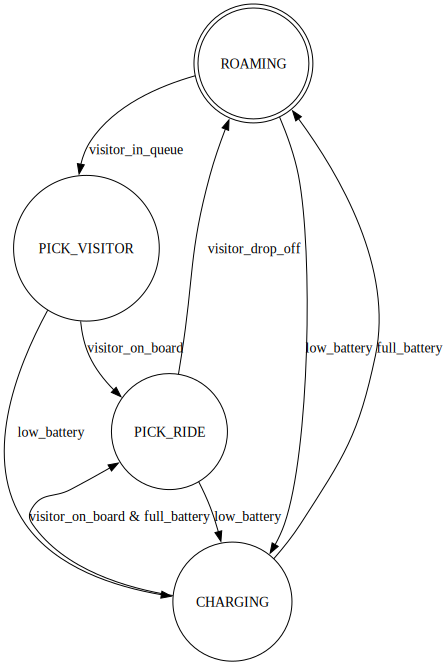

In [8]:
idx = 0
display(sim.robots[idx].state_machine.to_graphviz())